In [1]:
import numpy as np
from glm import BernoulliGLM, BernoulliGLMwReg, BernoulliGLMPyTorch
import pandas as pd

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
sim_data_path = './sim/save/pagsim_external_stimuli/'
use_torch = True

all_dfs = []
all_timings = []
all_binned_spikes = []
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]       

# extract all input spikes and bin them
for brain_region in brain_regions:
    df = extract_sim_as_df(sim_data_path, brain_region)
    all_dfs.append(df)
    timings = extract_timings(df, brain_region)
    all_timings.append(timings)

_total_length = np.max([total_length(df) for df in all_dfs])
for i, brain_region in enumerate(brain_regions):
    binned_spikes = (bin_spikes(all_timings[i], start_time=0, end_time=_total_length, bin_size=0.001))
    all_binned_spikes.append(binned_spikes)
    print(f'Average {brain_region} firing rate: {np.sum(binned_spikes) / len(all_timings[i]) / _total_length} Hz.')


pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[0,:][None,:]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / len(pag_timings) / _total_length} Hz.')

X_ones_step = np.vstack(all_binned_spikes)
X = np.repeat(X_ones_step, 1, axis=1) # repeat input timings (n_PAG_neuron) times
y = pag_binned_spikes.swapaxes(0,1).reshape(1,-1) # flatten all pag neurons out to (1, T * n_PAG_neurons)
assert X.shape[1] == y.shape[1]

2023-11-16 16:50:01.339 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 64 neurons and 240000 bins. Total number of spikes: 185530.0


Average VMH firing rate: 12.078791140155591 Hz.


2023-11-16 16:50:01.741 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 64 neurons and 240000 bins. Total number of spikes: 184813.0


Average ACC firing rate: 12.03211139430591 Hz.


2023-11-16 16:50:02.171 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 64 neurons and 240000 bins. Total number of spikes: 185029.0


Average IC firing rate: 12.046173911884056 Hz.


2023-11-16 16:50:02.525 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 64 neurons and 240000 bins. Total number of spikes: 185453.0


Average SC firing rate: 12.073778113055974 Hz.


2023-11-16 16:50:02.874 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 64 neurons and 240000 bins. Total number of spikes: 184994.0
2023-11-16 16:50:03.073 | DEBUG    | utils:bin_spikes:62 - Created spike bin matrix with 2 neurons and 240000 bins. Total number of spikes: 78838.0


Average PMD firing rate: 12.043895263202412 Hz.
Average PAG firing rate: 86.61260826576033 Hz.


In [5]:
# split dataset in half, train on first half
X_train, y_train = X[:, :int(X.shape[1]/2)], y[:, :int(y.shape[1]/2)]
X_test, y_test = X[:, int(X.shape[1]/2):], y[:, int(y.shape[1]/2):]

In [6]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([len(df) for df in all_dfs]),
    link_fn='logistic',
    reg_params=1,
    ).to(device)

glm.fit(X_train.T, y_train.T, n_iter=15000, lr=1e-3, verbose=1, decay=0.9998)
glm.load_best_params()

2023-11-16 16:50:19.420 | DEBUG    | glm:fit:258 - Training GLM with PyTorch. Initial log like: -86026.71875, inital loss: tensor([[86026.7734]])
2023-11-16 16:50:27.179 | DEBUG    | glm:fit:279 - Step 750. Log like: -44055.3828125,  loss: 44076.34375
2023-11-16 16:50:34.158 | DEBUG    | glm:fit:279 - Step 1500. Log like: -38302.5546875,  loss: 38497.57421875
2023-11-16 16:50:41.020 | DEBUG    | glm:fit:279 - Step 2250. Log like: -35838.921875,  loss: 36199.66015625
2023-11-16 16:50:47.909 | DEBUG    | glm:fit:279 - Step 3000. Log like: -34134.671875,  loss: 34504.921875
2023-11-16 16:50:54.952 | DEBUG    | glm:fit:279 - Step 3750. Log like: -32817.1640625,  loss: 33143.20703125
2023-11-16 16:51:01.858 | DEBUG    | glm:fit:279 - Step 4500. Log like: -31810.119140625,  loss: 32097.77734375
2023-11-16 16:51:08.772 | DEBUG    | glm:fit:279 - Step 5250. Log like: -31058.994140625,  loss: 31324.326171875
2023-11-16 16:51:15.595 | DEBUG    | glm:fit:279 - Step 6000. Log like: -30508.0546875,

In [7]:
with torch.no_grad():
    y_test_hat = glm(X_test.T).T

# R2 loss
import torch.nn.functional as F
print('R2 loss: ', float(F.mse_loss(torch.as_tensor(y_test, dtype=torch.float32), y_test_hat.cpu()).numpy()))

# Pearson's correlation
print("Pearson's correlation: ",np.corrcoef(y_test, y_test_hat.cpu())[0,1])
    
generated_spikes = generate_bernoulli_spikes(y_test_hat)

# smoothen with gaussian kernel

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

print('Correlation between smooth probability and test set spikes: ', np.corrcoef(smooth_y_test_hat, y_test)[0,1])
print('Correlation between smooth probability and smooth test set spikes: ', np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])
print('Correlation between smooth generated spikes and smooth test set spikes: ', np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])

R2 loss:  0.2118338793516159
Pearson's correlation:  0.18332638469606624
Correlation between smooth probability and test set spikes:  0.140345542448321
Correlation between smooth probability and smooth test set spikes:  0.6951017524442625
Correlation between smooth generated spikes and smooth test set spikes:  0.1658648046845307


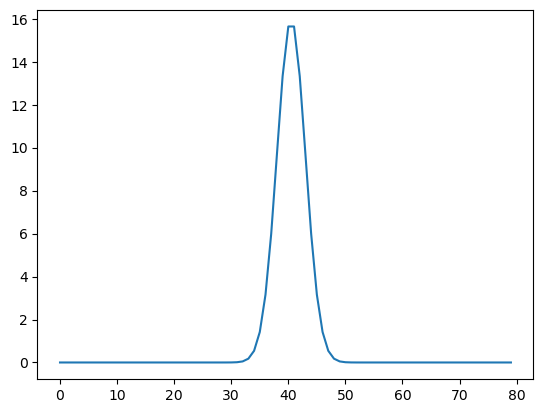

In [92]:
test_array = np.zeros(1000)
test_array[[500]] = 1
plt.plot(rbf_rate_convolution_1d(test_array, sigma=0.025)[460:540])

Corr btwn GLM and Syn for VMH:  0.9334468612039332


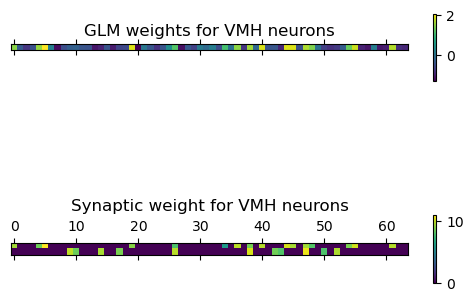

Corr btwn GLM and Syn for ACC:  0.9043175101516848


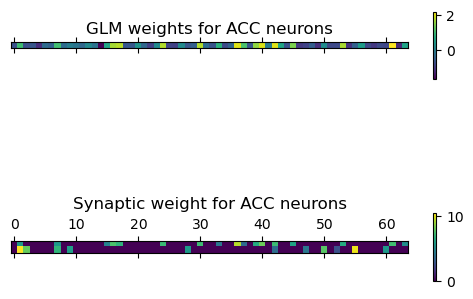

Corr btwn GLM and Syn for IC:  0.9193101318706716


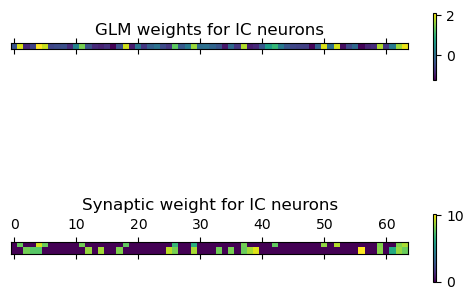

Corr btwn GLM and Syn for SC:  0.8938531360945091


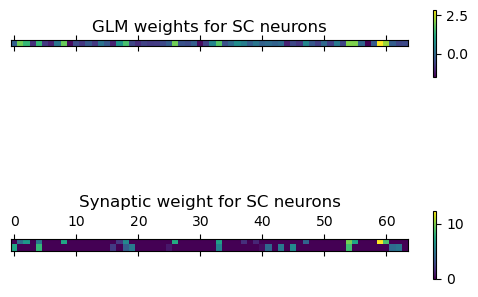

Corr btwn GLM and Syn for PMD:  0.9456443821828548


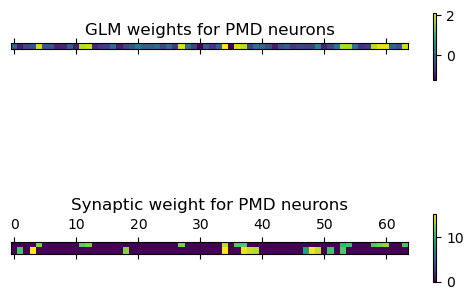

In [11]:
corrs = []
for i, brain_region in enumerate(brain_regions):
    glm_w = glm.best_weight[:,glm.neuron_group_cumsum[i]:glm.neuron_group_cumsum[i+1]].cpu()
    conn = np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0) * 1e9
    
    corr = np.corrcoef(glm_w[0,:], conn[:,0])[0,1]
    corrs.append(corr)
    print(f'Corr btwn GLM and Syn for {brain_region}: ', corr)
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True)
    m = axes[0].matshow(normalise_array(glm_w))
    f.colorbar(m, shrink=0.4)
    axes[0].set_title(f'GLM weights for {brain_region} neurons')
    axes[0].set_yticks([])

    m = axes[1].matshow(conn.T)
    f.colorbar(m, shrink=0.4)
    axes[1].set_title(f'Synaptic weight for {brain_region} neurons')
    axes[1].set_yticks([])

    plt.show()

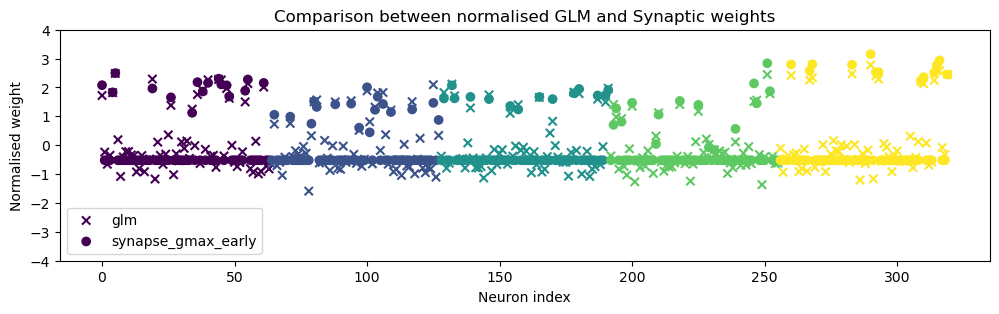

In [36]:
glm_ws = glm.best_weight.cpu()[0,:]
brian2_ws = np.concatenate([np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy')[:,0], nan=0.0) for brain_region in brain_regions])
plt.figure(figsize=(12,3))
plt.scatter(np.arange(320), normalise_array(glm_ws), marker='x', c=glm.neuron_group_idx, label='glm')
plt.scatter(np.arange(320), normalise_array(brian2_ws), marker='o', c=glm.neuron_group_idx, label='synapse_gmax_early')
plt.xlabel('Neuron index')
plt.ylabel('Normalised weight')
plt.ylim([-4,4])
plt.legend(loc='best')
plt.title('Comparison between normalised GLM and Synaptic weights')
plt.savefig('./figs/w_glm_b2_comparison', dpi=350, bbox_inches='tight')
plt.show()

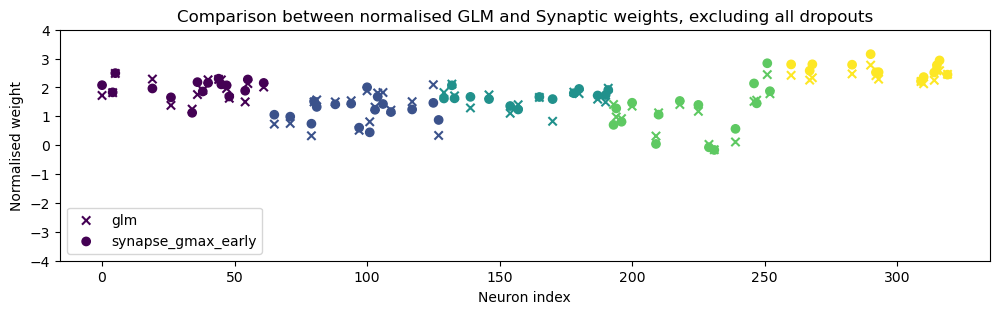

In [37]:
non_zero_idx = np.where(brian2_ws > 0)[0]
plt.figure(figsize=(12,3))
plt.scatter(non_zero_idx, normalise_array(glm_ws)[non_zero_idx], marker='x', c=glm.neuron_group_idx[non_zero_idx], label='glm')
plt.scatter(non_zero_idx, normalise_array(brian2_ws)[non_zero_idx], marker='o', c=glm.neuron_group_idx[non_zero_idx], label='synapse_gmax_early')
plt.xlabel('Neuron index')
plt.ylabel('Normalised weight')
plt.ylim([-4,4])
plt.legend(loc='best')
plt.title('Comparison between normalised GLM and Synaptic weights, excluding all dropouts')
plt.savefig('./figs/w_glm_b2_comparison_non_zero', dpi=350, bbox_inches='tight')
plt.show()

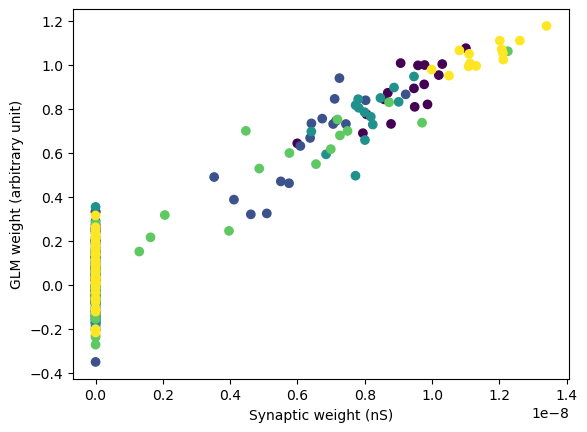

In [38]:
plt.scatter(brian2_ws, glm_ws, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (nS)')
plt.ylabel('GLM weight (arbitrary unit)')
plt.show()

In [41]:
glm.best_bias

tensor([-3.1433], device='cuda:0')

In [3]:
reg_params = [0, .001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100]
corrss = []
for i, reg_param in enumerate(reg_params):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    glm = BernoulliGLMPyTorch(
        n_neurons_per_group=np.array([len(df) for df in all_dfs]),
        link_fn='logistic',
        reg_params=reg_param,
        ).to(device)

    glm.fit(X.T, y.T, n_iter=10000, lr=1e-3, verbose=0)
    # glm.load_best_params()
    
    corrs = []
    for m, brain_region in enumerate(brain_regions):
        glm_w = glm.best_weight[:,glm.neuron_group_cumsum[m]:glm.neuron_group_cumsum[m+1]].cpu()
        conn = np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0) * 1e9
        
        corr = np.corrcoef(glm_w[0,:], conn[:,0])[0,1]
        corrs.append(corr)
    print(f'({i+1} / {len(reg_params)}) Testing regularisaiton parameter {reg_param}, correlations: {corrs}')
    corrss.append(corrs)

2023-11-13 14:36:11.822 | DEBUG    | glm:fit:258 - Training GLM with PyTorch. Initial log like: -8534.3359375, inital loss: tensor([[8534.3359]])


KeyboardInterrupt: 

Text(0.5, 1.0, 'Correlation between GLM weights and Brian2 weights')

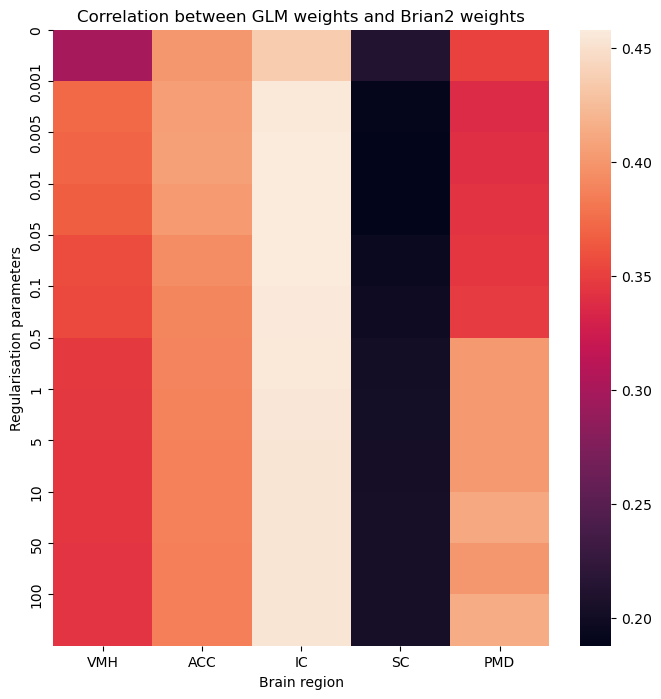

In [15]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(np.array(corrss))
plt.xticks(np.arange(5)+0.5, brain_regions)
plt.xlabel('Brain region')
plt.ylabel('Regularisation parameters')
plt.yticks(np.arange(len(reg_params)), reg_params)
plt.title('Correlation between GLM weights and Brian2 weights')